In [41]:
from transformers import AutoImageProcessor, AutoModel
import torch

import matplotlib.pyplot as plt
import numpy as np

model_name = "facebook/dinov3-vitl16-pretrain-sat493m"  # smaller + sat-trained

processor = AutoImageProcessor.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).eval().to(device)

print("device:", device)


device: cuda


## Show features map
patch tokens → PCA(3) → 14×14×3 → bilinear upscale for display only


In [42]:

from PIL import Image
img = Image.open("/home/mak/PycharmProjects/SegEdge/experiments/get_data_from_api/patches_mt/test.tif").convert("RGB")

inputs = processor(images=img,return_tensors="pt").to(device)
x = inputs['pixel_values']
print("input shape:", x.shape)


input shape: torch.Size([1, 3, 224, 224])


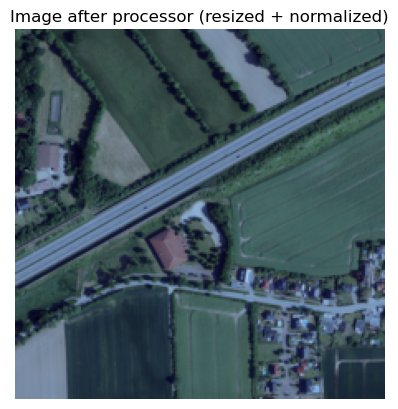

In [43]:
# take the tensor `x` that we gave to the model:
# shape is (1, 3, 224, 224)
# we remove the batch dimension [0], move channels to last position (H, W, C)
# and convert to a NumPy array for plotting
img_proc = x[0].cpu().permute(1, 2, 0).numpy()


# the processor normalized pixel values (roughly between -1 and +1)
# we shift and scale them back to 0–1 so matplotlib can display them
img_proc = (img_proc - img_proc.min()) / (img_proc.max() - img_proc.min())

# display the 224×224 image that the processor actually fed into the model
plt.imshow(img_proc)
plt.title("Image after processor (resized + normalized)")
plt.axis("off")                      # remove axis ticks for cleaner display
plt.show()

In [44]:
with torch.no_grad():                              # no gradients during inference
    out = model(pixel_values=x.to(device))         # forward pass -> tokens
tok = out.last_hidden_state                        # shape: (B, 1+R+P, D)
R = getattr(model.config, "num_register_tokens", 0)# how many non-spatial register tokens
patch = tok[:, 1+R:, :]                            # drop CLS+registers -> (B, P, D) = (1, 196, 1024)
print("patch shape:", tuple(patch.shape))          # expect (1, 196, 1024)


patch shape: (1, 196, 1024)


In [45]:
# compute patch size and how many patches fit per side (H/ps, W/ps)
ps = getattr(model.config, "patch_size", 16)

# number of patches along height and width (for 224 and ps=16 → 14x14)
Hp, Wp = x.shape[2] // ps, x.shape[3] // ps

# move feature array to CPU and convert to NumPy (shape: 196×1024)
F = patch[0].cpu().numpy()
print("feature array shape:", F.shape)   # expect (196, 1024)

# Where 196 is 14×14 patches, and 1024 is feature dimension D

feature array shape: (196, 1024)


In [46]:
# import PCA and reduce 1024-D features → 3-D for RGB visualization
from sklearn.decomposition import PCA

# fit PCA on patch features, then transform them to 3 components
pcs = PCA(n_components=3).fit_transform(F)    # shape: (196, 3)

# reshape flat (196×3) PCA output → patch grid (14×14×3)
pc_grid = pcs.reshape(Hp, Wp, 3)

# normalize values to 0–1 for display (so min=0, max=1)
pc_show = (pc_grid - pc_grid.min()) / (pc_grid.max() - pc_grid.min())
print("PCA image shape:", pc_show.shape)   # expect (14, 14, 3)
#Where 14x14 is the patch grid, and 3 is RGB

PCA image shape: (14, 14, 3)


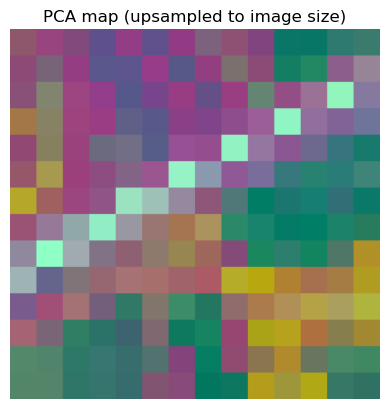

In [47]:
# import libraries for display and upsampling
import numpy as np
import matplotlib.pyplot as plt

# upsample patch grid back to image resolution by repeating each patch 16×16 times
rgb_ups = np.kron(pc_show, np.ones((ps, ps, 1)))  # (224×224×3)

# display the PCA-based color map
plt.imshow(rgb_ups)
plt.axis("off")
plt.title("PCA map (upsampled to image size)")
plt.show()


In [48]:
# import interpolation function
import torch.nn.functional as F

# convert the (14,14,1024) NumPy grid back to a PyTorch tensor and rearrange axes to (1,1024,14,14)
feat = torch.tensor(pc_grid).permute(2, 0, 1).unsqueeze(0)

# upsample the feature map to the original image size (224×224)
feat_up = F.interpolate(feat, size=(224, 224), mode="bilinear", align_corners=False)

# move to CPU and convert back to NumPy for PCA visualization
feat_up_np = feat_up.squeeze(0).permute(1, 2, 0).cpu().numpy()   # shape: (224,224,1024)
print("upsampled feature map:", feat_up_np.shape)


upsampled feature map: (224, 224, 3)


In [49]:
# flatten the upsampled features to a list of 224×224 = 50176 pixels, each with 1024-D features
pixels = feat_up_np.reshape(-1, feat_up_np.shape[-1])

# apply PCA again to reduce 1024-D → 3-D for visualization
from sklearn.decomposition import PCA
pca2 = PCA(n_components=3).fit_transform(pixels)
pca_img = pca2.reshape(224, 224, 3)


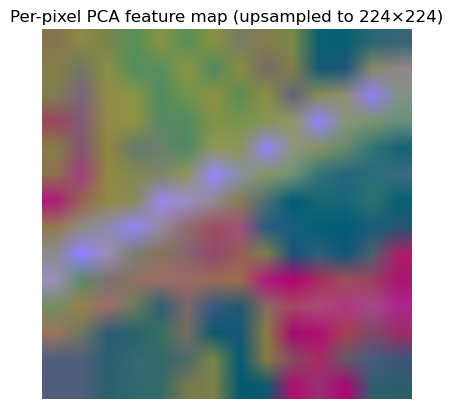

In [50]:
# normalize PCA output to 0–1 range for display
pca_img = (pca_img - pca_img.min()) / (pca_img.max() - pca_img.min())

# plot the high-resolution PCA map
import matplotlib.pyplot as plt
plt.imshow(pca_img)
plt.title("Per-pixel PCA feature map (upsampled to 224×224)")
plt.axis("off")
plt.show()


## Paper Way
patch tokens → bilinear upscale → PCA → 224×224×3

In [51]:
# test a 1024×1024 image first; this usually fits in 8 GB for ViT-L/16
inputs = processor(images=img, size=2048, return_tensors="pt")
x = inputs["pixel_values"].to(device)
print("input:", tuple(x.shape))

with torch.no_grad():
    _ = model(pixel_values=x)
print("✅ 2048² forward ok")


input: (1, 3, 2048, 2048)
✅ 2048² forward ok


In [52]:
# forward pass already done; extract patch tokens
R = getattr(model.config, "num_register_tokens", 0)
patch = _.last_hidden_state[:, 1+R:, :]          # (1, P, D)

# reshape to 2D grid (128×128×1024)
Hp = Wp = 2048 // 16
patch_grid = patch.reshape(1, Hp, Wp, patch.shape[-1])
print("grid:", tuple(patch_grid.shape))


grid: (1, 128, 128, 1024)


In [53]:
# move the 128×128×1024 feature grid to CPU and convert to NumPy
feat = patch_grid[0].cpu().numpy()

# flatten patches so PCA sees one 1024-D vector per patch (16384×1024)
flat = feat.reshape(-1, feat.shape[-1])
print("flattened:", flat.shape)


flattened: (16384, 1024)


In [54]:
# run PCA to compress 1024-D → 3-D
from sklearn.decomposition import PCA

# fitting PCA on all 16 384 patch tokens
pcs = PCA(n_components=3).fit_transform(flat)  # (16384×3)

# reshape back to spatial grid (128×128×3)
pc_grid = pcs.reshape(128, 128, 3)


In [55]:
# normalize PCA values to [0,1] for visualization
pc_norm = (pc_grid - pc_grid.min()) / (pc_grid.max() - pc_grid.min() + 1e-8)

# optional: L2 normalize each pixel for stronger contrast
import numpy as np
pc_norm /= np.linalg.norm(pc_norm, axis=-1, keepdims=True) + 1e-8
pc_norm = np.clip(pc_norm, 0, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07017825..1.0386971].


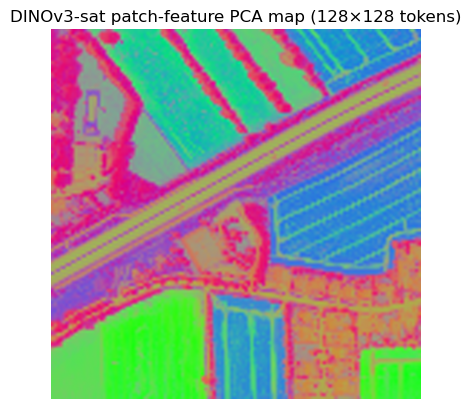

In [56]:
# import visualization tools
import matplotlib.pyplot as plt
import torch.nn.functional as F

# enlarge the 128×128 PCA map for display only (e.g. to 1024×1024)
pc_torch = torch.tensor(pc_norm).permute(2,0,1).unsqueeze(0)
pc_big = F.interpolate(pc_torch, size=(1024,1024), mode="bicubic", align_corners=False)

# plot the crisp, paper-style PCA map
plt.imshow(pc_big[0].permute(1,2,0))
plt.title("DINOv3-sat patch-feature PCA map (128×128 tokens)")
plt.axis("off")
plt.show()


## With Standardized Features


In [57]:
# import the StandardScaler to normalize each feature dimension
from sklearn.preprocessing import StandardScaler

# create a scaler that will make each of the 1024 feature columns mean=0, std=1
scaler = StandardScaler()

# fit the scaler on all patch features (flat: 16384×1024) and apply the transform
flat_std = scaler.fit_transform(flat)

# print shape and a small sample to confirm scaling worked
print("standardized shape:", flat_std.shape, "mean≈", flat_std.mean(), "std≈", flat_std.std())


standardized shape: (16384, 1024) mean≈ -7.601102e-10 std≈ 1.0000001


In [58]:
# import PCA again for clarity and create a whitening PCA (each component scaled to unit variance)
from sklearn.decomposition import PCA
pca_whiten = PCA(n_components=3, whiten=True)

# fit PCA on standardized features and get the top 3 principal components
pcs = pca_whiten.fit_transform(flat_std)

# check the result shape to confirm we have 3 new color channels
print("PCA output shape:", pcs.shape, "explained variance ratio:", pca_whiten.explained_variance_ratio_)


PCA output shape: (16384, 3) explained variance ratio: [0.13000579 0.08484551 0.07174242]


In [59]:
# reshape the flat PCA output (16384×3) into its 2-D spatial layout (128×128×3)
pc_grid = pcs.reshape(128, 128, 3)

# check the new shape to confirm it matches your patch grid size
print("PCA grid shape:", pc_grid.shape)

# verify that values now correspond to each patch location
print("value range:", pc_grid.min(), "to", pc_grid.max())

# this grid is the low-resolution "feature map" we’ll later normalize and display


PCA grid shape: (128, 128, 3)
value range: -2.5842505 to 3.1966465


In [60]:
# shift and scale all PCA values into the 0–1 range for color display
pc_norm = (pc_grid - pc_grid.min()) / (pc_grid.max() - pc_grid.min() + 1e-8)

# verify that normalization worked correctly
print("normalized range:", pc_norm.min(), "to", pc_norm.max())

# check the shape again (should still be 128×128×3)
print("normalized grid shape:", pc_norm.shape)

# this version can now be mapped directly to RGB for viewing


normalized range: 0.0 to 1.0
normalized grid shape: (128, 128, 3)


Displaying PCA map at native patch resolution: 128×128 (one color per 16×16 patch).


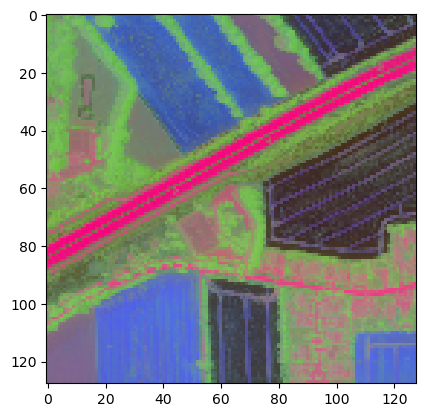

In [61]:
# import plotting library to render the PCA grid as an image
import matplotlib.pyplot as plt

# print a reminder that this is the native 128×128 patch grid (no interpolation applied)
print("Displaying PCA map at native patch resolution: 128×128 (one color per 16×16 patch).")

# show the normalized 3-channel PCA grid exactly as-is (nearest keeps patch blocks visible)
plt.imshow(pc_norm, interpolation="nearest")

# display the figure window
plt.show()


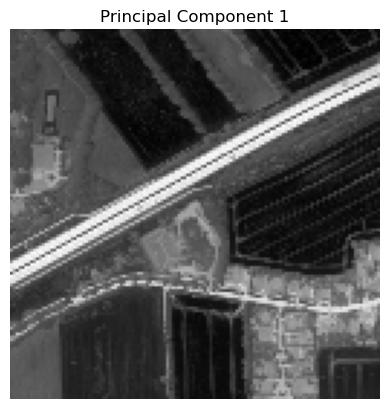

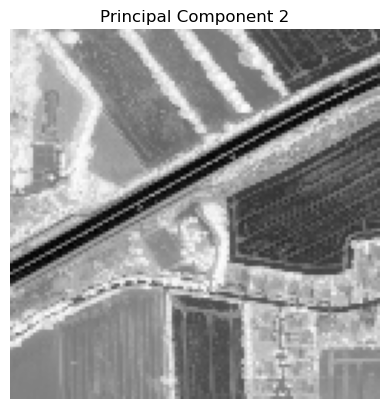

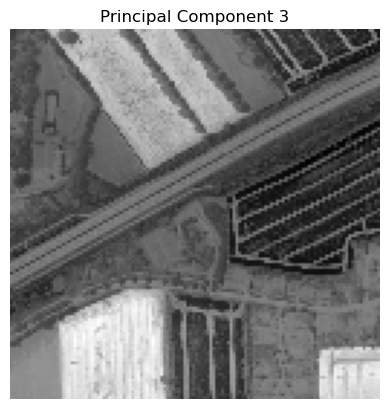

In [62]:
# visualize the first few principal components individually
import matplotlib.pyplot as plt

for i in range(3):
    plt.imshow(pc_grid[..., i], cmap="gray")
    plt.title(f"Principal Component {i+1}")
    plt.axis("off")
    plt.show()
